In [29]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [30]:
# Hente inn datasettet
combined_df = pd.read_csv('combined.csv')

In [31]:
# Sjekker om er riktig
combined_df.drop('Unnamed: 0', axis=1, inplace=True)
combined_df.drop('dnr_status', axis=1, inplace=True)
combined_df.drop('dnr_dag', axis=1, inplace=True)
combined_df.drop('adl_pasient', axis=1, inplace=True)
combined_df.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,...,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd
0,2,60.33899,female,12.0,$11-$25k,white,1,4.0,43.0,17.097656,...,1.0,52.695312,74.0,0.001000,0.000000,0,0,no,0.00,0.0
1,3,52.74698,female,12.0,under $11k,white,0,17.0,70.0,8.500000,...,0.0,20.500000,45.0,0.790894,0.664917,0,0,no,0.75,0.5
2,4,42.38498,female,11.0,under $11k,white,0,3.0,75.0,9.099609,...,0.0,20.097656,19.0,0.698975,0.411987,0,0,metastatic,0.90,0.5
3,6,93.01599,male,14.0,NaN,white,1,4.0,110.0,10.398438,...,1.0,19.398438,27.0,0.284973,0.214996,0,0,no,0.00,0.0
4,7,62.37097,male,14.0,$25-$50k,white,0,9.0,78.0,11.699219,...,1.0,17.296875,46.0,0.892944,0.820923,0,0,no,NaN,0.7


# Data preprocess

In [32]:
# Preprocess the data
X = combined_df.drop(['pasient_id', 'oppholdslengde'], axis=1)
y = combined_df['oppholdslengde']

#  Model laging og evaluering

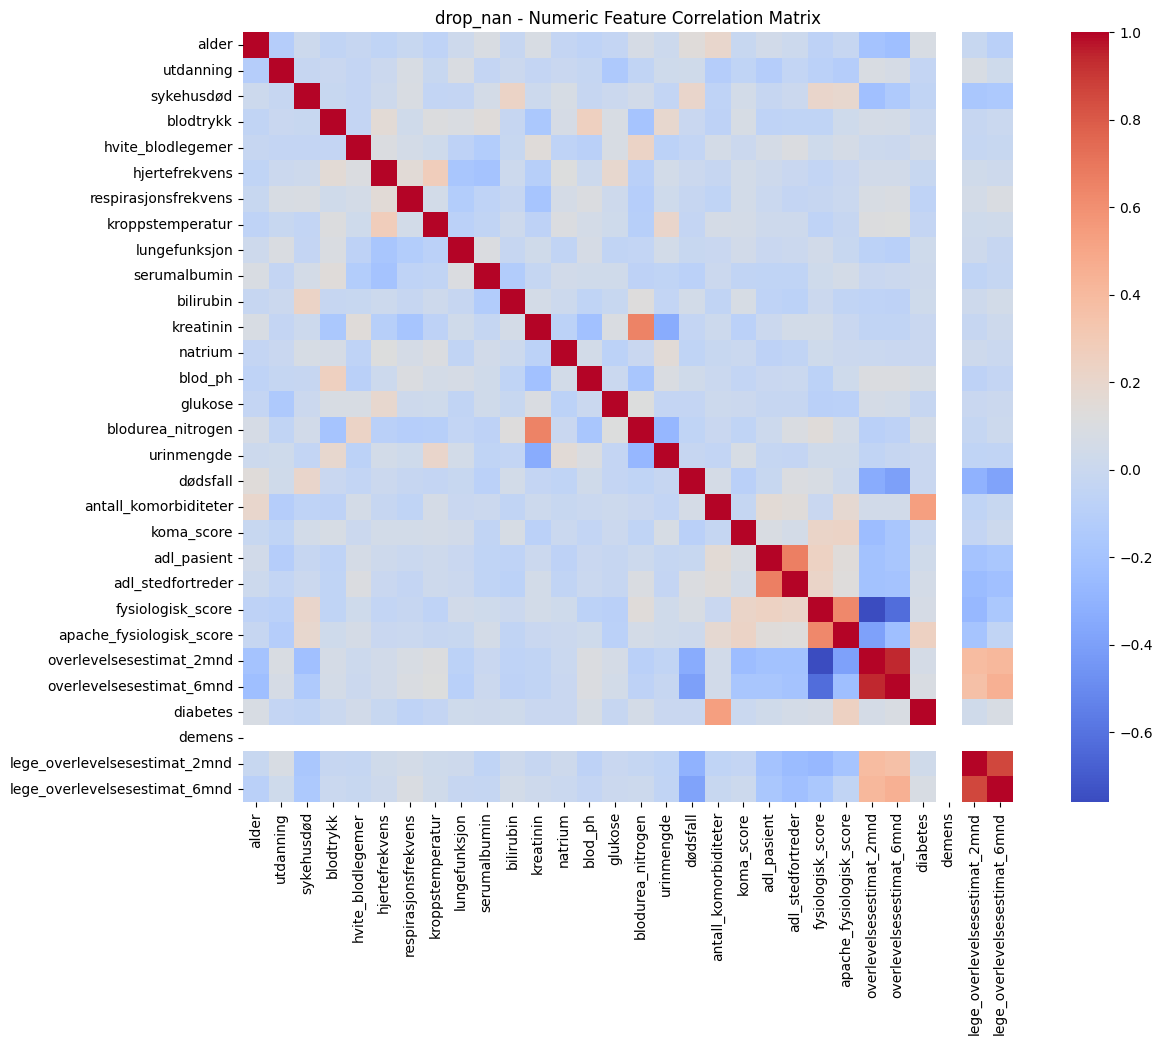

Random Forest: 9.853936838244968
Gradient Boosting: 9.903347741940646
Decision Tree: 12.877040879727835
Linear Regression: 10.036496820252154
Polynomial Regression: 11.7232483931102
Ridge Regression: 9.854112377193994
drop_nan - Best Model: Random Forest
drop_nan - Validation RMSE: 9.85


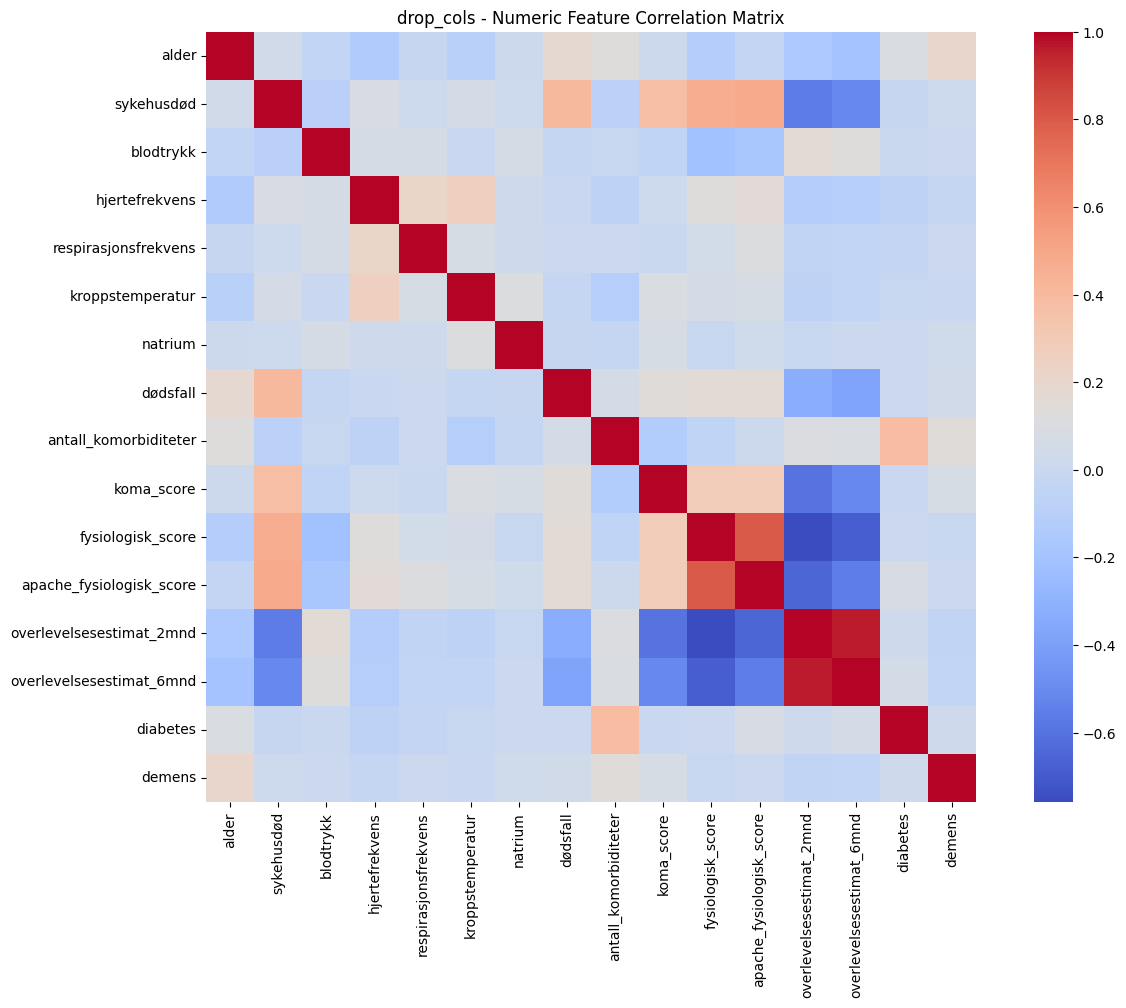

Random Forest: 23.347446713646693
Gradient Boosting: 23.11858712795693
Decision Tree: 30.45485280720314
Linear Regression: 23.42199974169499
Polynomial Regression: 46565848.01321979
Ridge Regression: 23.421100966454524
drop_cols - Best Model: Gradient Boosting
drop_cols - Validation RMSE: 23.12


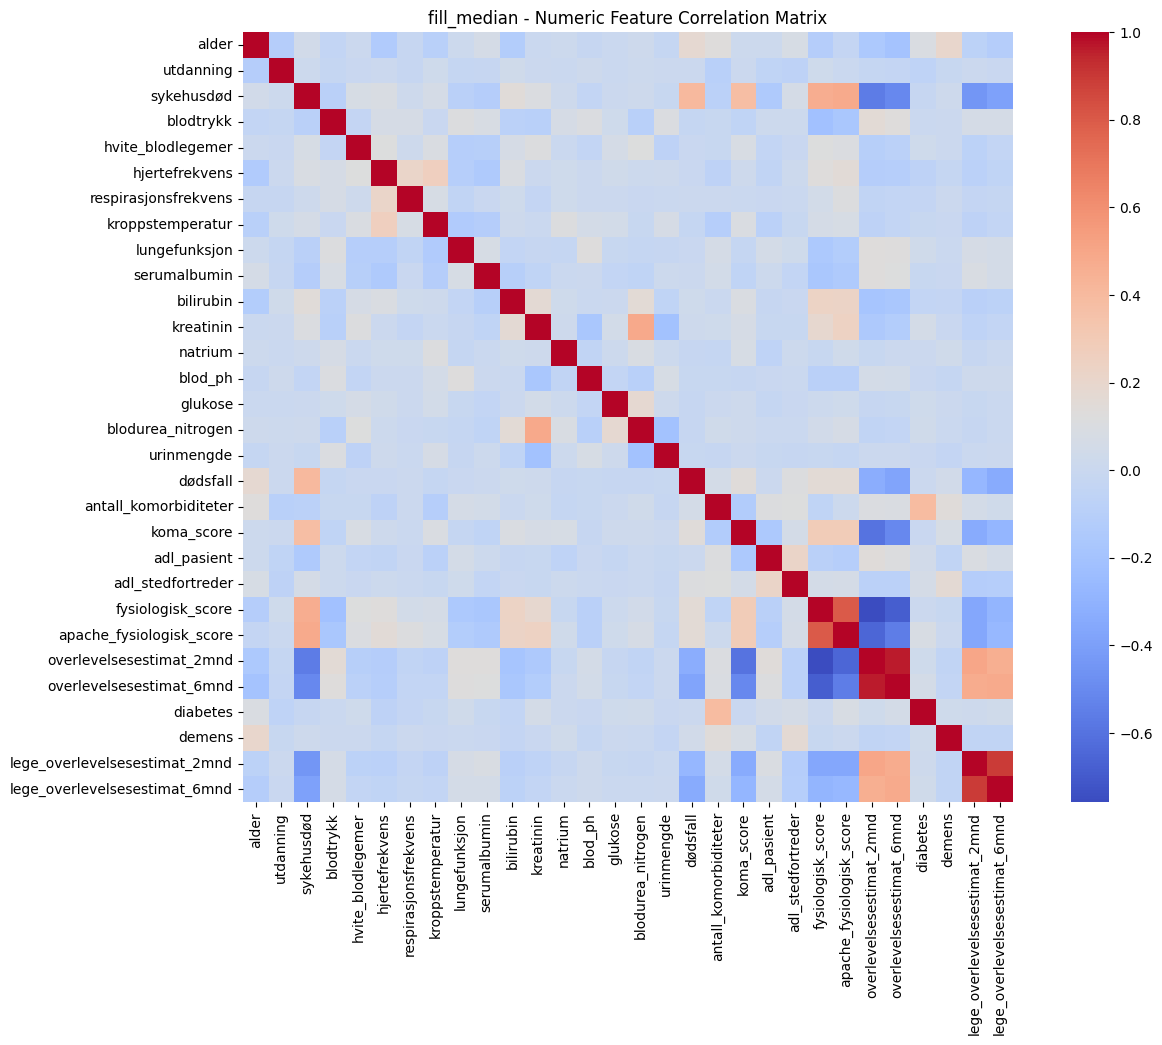

Random Forest: 23.244142360496596
Gradient Boosting: 23.120151610754906
Decision Tree: 28.620809064622605
Linear Regression: 23.42309242948602
Polynomial Regression: 30348113813.044415
Ridge Regression: 23.421817336986955
fill_median - Best Model: Gradient Boosting
fill_median - Validation RMSE: 23.12


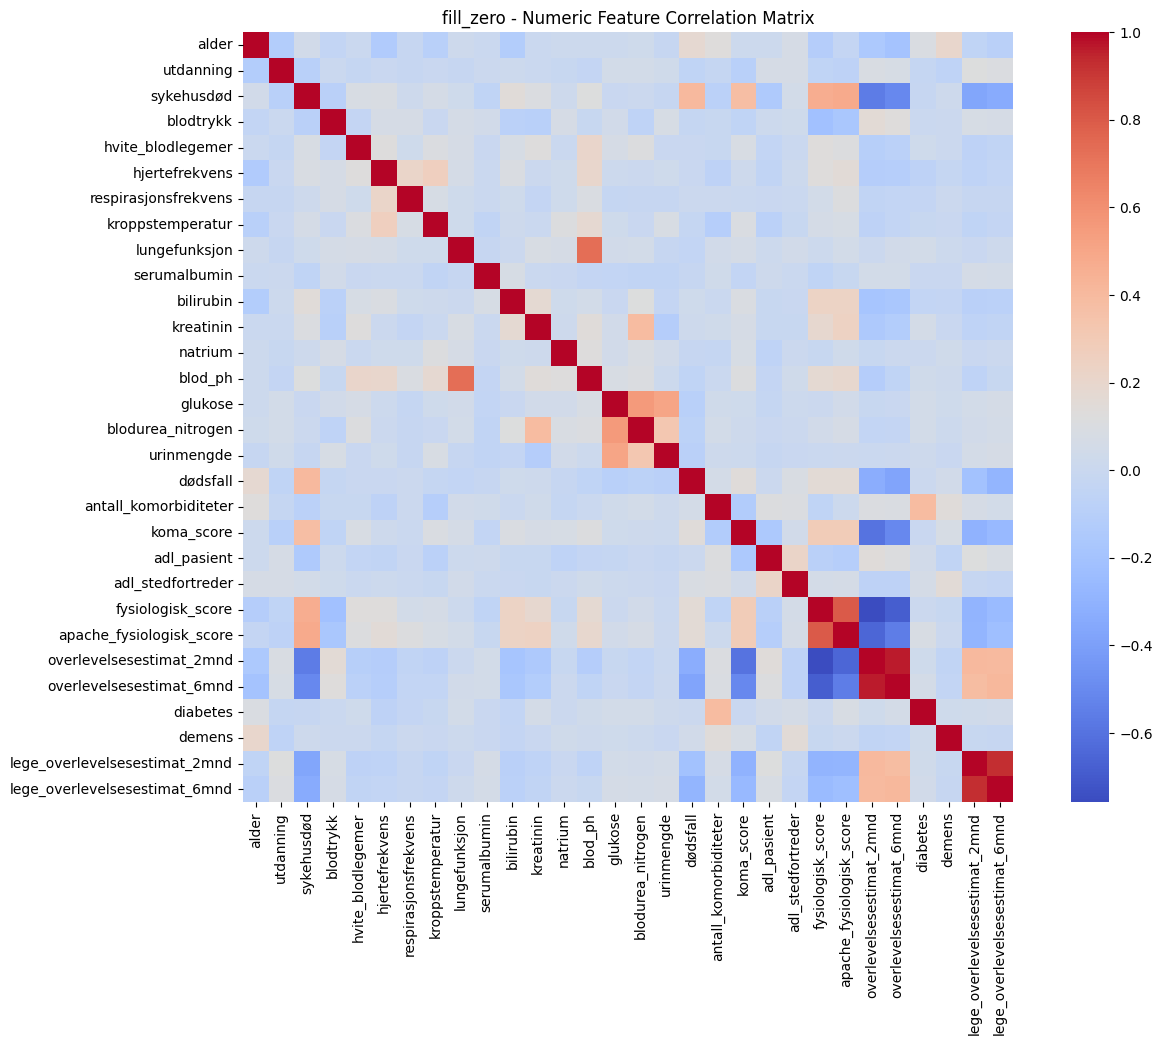

Random Forest: 23.046882300314586
Gradient Boosting: 23.1372549947639
Decision Tree: 28.796134029730705
Linear Regression: 23.4321958979064
Polynomial Regression: 108127013590.1507
Ridge Regression: 23.430841348115866
fill_zero - Best Model: Random Forest
fill_zero - Validation RMSE: 23.05


In [33]:
# Lage 6 forskjellige modeller
strategies = ['drop_nan', 'drop_cols', 'fill_median', 'fill_zero']
models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'Linear Regression', 'Polynomial Regression', 'Ridge Regression',]
model_pipelines = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=24),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=24),
    'Decision Tree': DecisionTreeRegressor(random_state=24),
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Store de beste modellene
best_models = {}
validation_rmse = {}

# Lage de 4 forskjellige strategier for å håndtere Nan
for strategy in strategies:
    if strategy == 'drop_nan':
        X_strategy = X.dropna()
        y_strategy = y[X_strategy.index]
    elif strategy == 'drop_cols':
        nan_counts = X.isnull().sum()
        threshold = 0
        X_strategy = X.drop(columns=nan_counts[nan_counts > threshold].index)
        X_strategy = X_strategy.fillna(0)
        y_strategy = y
    elif strategy == 'fill_median':
        X_fill_median = X.copy()
        median_cols = X_fill_median.select_dtypes(include=['int64', 'float64']).columns
        X_fill_median[median_cols] = X_fill_median[median_cols].fillna(X_fill_median[median_cols].median())
        y_fill_median = y

        X_strategy = X_fill_median
        y_strategy = y_fill_median
    else:
        X_strategy = X.fillna(0)
        y_strategy = y

    # Correlation matrix
    numeric_cols = X_strategy.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = X_strategy[numeric_cols].corr()
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True, ax=ax)
    plt.title(f'{strategy} - Correlation Matrix')
    plt.show()

    categorical_cols = X_strategy.select_dtypes(exclude=['int64', 'float64']).columns
    numerical_cols = [col for col in X_strategy.columns if col not in categorical_cols]

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('converter', FunctionTransformer(lambda x: x.astype(str))),  # Convert to strings
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Split te train (60%), validation (20%), and test (20%)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_strategy, y_strategy, test_size=0.2, random_state=24)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=24)  # 0.25 * 0.8 = 0.2

    best_rmse = float('inf')
    best_model_name = None
    best_model_pipeline = None

    for model_name in models:
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model_pipelines[model_name])
        ])

        model_pipeline.fit(X_train, y_train)
        y_val_pred = model_pipeline.predict(X_val)
        rmse_val = root_mean_squared_error(y_val, y_val_pred)
        print(f'{model_name}: {rmse_val}')
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_model_name = model_name
            best_model_pipeline = model_pipeline

    best_models[strategy] = best_model_pipeline
    validation_rmse[strategy] = best_rmse

    print(f'{strategy} - Best Model: {best_model_name}')
    print(f'{strategy} - Validation RMSE: {best_rmse:.2f}')

# Sammenligne med full dataset

In [34]:
# Compare med det orginalle datasettet
for strategy in strategies:
    best_model_pipeline = best_models[strategy]

    # Split te train (60%), validation (20%), and test (20%)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=24)  # 0.25 * 0.8 = 0.2

    best_model_pipeline.fit(X_train, y_train)
    y_test_pred = best_model_pipeline.predict(X_val)
    rmse_test = root_mean_squared_error(y_val, y_test_pred)

    print(f'{strategy} - Test RMSE på full dataset (Combined_df): {rmse_test:.2f}')

drop_nan - Test RMSE on full dataset (Combined_df): 20.54
drop_cols - Test RMSE on full dataset (Combined_df): 20.52
fill_median - Test RMSE on full dataset (Combined_df): 20.34
fill_zero - Test RMSE on full dataset (Combined_df): 20.54


In [35]:
# Finne % av data med differanse mindre enn 10
for strategy in strategies:
    best_model_pipeline = best_models[strategy]
    best_model_pipeline.fit(X_train, y_train)
    y_test_pred = best_model_pipeline.predict(X_test)

    X_test_filled = X_test.copy()
    X_test_filled['predicted_value'] = y_test_pred
    diffs = (X_test_filled['predicted_value']) - y_test
    diff_counts = {}
    for diff in diffs:
        diff = round(diff)  # Round til heltall
        if diff in diff_counts:
            diff_counts[diff] += 1
        else:
            diff_counts[diff] = 1

    total_less_than_10 = sum(count for diff, count in diff_counts.items() if abs(diff) < 10)
    total_diffs = len(diffs)
    percentage_less_than_10 = (total_less_than_10 / total_diffs) * 100

    print(f'{strategy} - Prosent av data med forskjell mindre enn 10 på full dataset (Comibined_df): {percentage_less_than_10:.2f}%')

drop_nan - Percentage of data with difference less than 10 on full dataset (Comibined_df): 62.10%
drop_cols - Percentage of data with difference less than 10 on full dataset (Comibined_df): 62.68%
fill_median - Percentage of data with difference less than 10 on full dataset (Comibined_df): 63.58%
fill_zero - Percentage of data with difference less than 10 on full dataset (Comibined_df): 62.10%
